<a href="https://colab.research.google.com/github/Natali-bali/TensorFlow_Tutorial/blob/master/10_Time_series_bitcoin_forcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Time series forecasting in TensorFlow (BitPredict 💰📈)

The goal of this notebook is to get you familiar with working with time series data.

We're going to be building a series of models in an attempt to predict the price of Bitcoin.

### Get helper functions

In [1]:
!wget 'https://raw.githubusercontent.com/Natali-bali/TensorFlow_Tutorial/master/helper_functions.py'

--2021-08-04 09:11:41--  https://raw.githubusercontent.com/Natali-bali/TensorFlow_Tutorial/master/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11016 (11K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.76K  --.-KB/s    in 0s      

2021-08-04 09:11:41 (62.5 MB/s) - ‘helper_functions.py’ saved [11016/11016]



### Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from datetime import datetime

import tensorflow as tf
from tensorflow.keras import backend as K 
from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from tensorflow.keras.layers import Dense, InputLayer, Lambda, Conv1D, LSTM

### Get Data
Historical data of Bitcoin

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2021-08-04 09:11:43--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.03s   

2021-08-04 09:11:44 (5.76 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



In [4]:
df = pd.read_csv('/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv')

In [5]:
df.Date = pd.to_datetime(df.Date)
df = df.rename(columns = {'Date': 'date'}).set_index('date')

In [6]:
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [7]:
df_bc = df[['Closing Price (USD)']].rename(columns = {'Closing Price (USD)':'price'})

In [8]:
df_bc.head()

,price
date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


### Inspect our data

Text(0.5, 1.0, 'Price of bitcoin from 1 Oct 2013 to 18 May 2021')

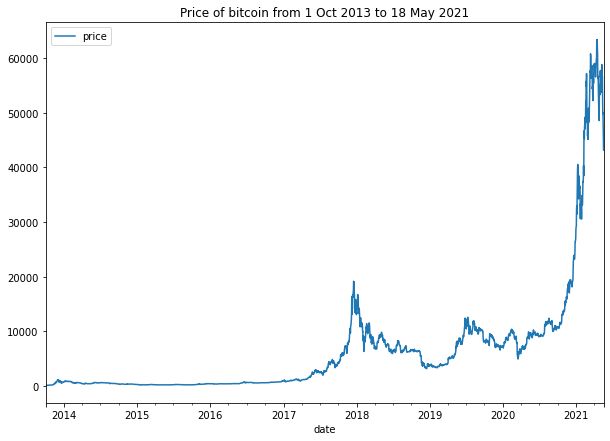

In [9]:
df_bc.plot(figsize = (10,7))
plt.title('Price of bitcoin from 1 Oct 2013 to 18 May 2021')

In [10]:
df_bc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   2787 non-null   float64
dtypes: float64(1)
memory usage: 43.5 KB


### Read Data with Python csv

In [11]:
timesteps = []
btc_price = []
with open('/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv', 'r') as f:
  csv_reader = csv.reader(f, delimiter = ',')
  next(csv_reader) #skip first line (header)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], '%Y-%m-%d'))
    btc_price.append(float(line[2]))

In [12]:
timesteps[:2], btc_price[:2]

([datetime.datetime(2013, 10, 1, 0, 0), datetime.datetime(2013, 10, 2, 0, 0)],
 [123.65499, 125.455])

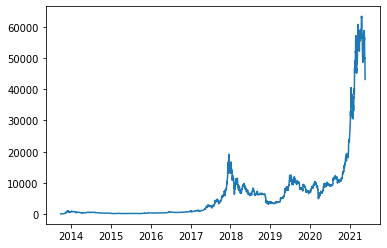

In [13]:
plt.plot(timesteps, btc_price)

### Create test train data sets

In [14]:
train_length = int(0.8*len(timesteps))
X_train, y_train = timesteps[:train_length], btc_price[:train_length]
X_test, y_test = timesteps[train_length:], btc_price[train_length:]

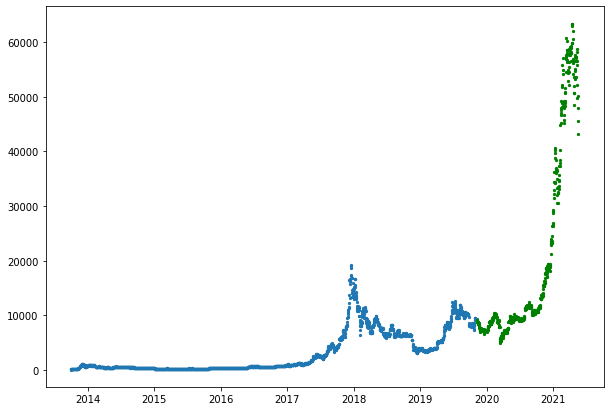

In [15]:
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s = 5, label = 'Train data')
plt.scatter(X_test, y_test, s = 5, label = 'Test data', c = 'green')
plt.show()

### Helper function to plot time series

In [16]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

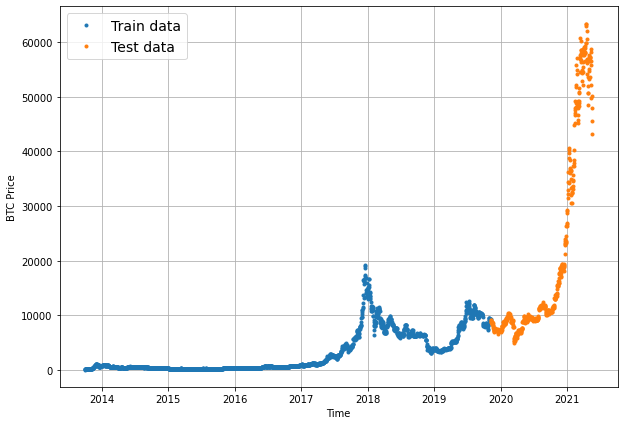

In [17]:
# Try out our plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

## Modelling Experiments

horizon = number of timesteps to predict into future

window = number of timesteps from past used to predict horizon

For example, if we wanted to predict the price of Bitcoin for tomorrow (1 day in the future) using the previous week's worth of Bitcoin prices (7 days in the past), the horizon would be 1 and the window would be 7.

We are going to do those modelling experiments:

- 0 Naïve model (baseline)
- 1	Dense model	horizont 1 window 7
- 2	Same as 1	horizont 1 window	30
- 3	Same as 1	horizont 7 window	30
- 4	Conv1D	horizont 1	window 7
- 5	LSTM	horizont 1	window 7
- 6	Same as 1 (but with multivariate data)	horizont 1	window 7	Block reward size
- 7	N-BEATs Algorithm	horizont 1	window 7
- 8	Ensemble (multiple models optimized on different loss functions)	horizont 1	window 7
- 9	Future prediction model (model to predict future values) horizont	1 window	7
- 10	Same as 1 (but with turkey 🦃 data introduced)	horizont 1	window 7	


### 0 Model: Naive
$$\hat{y}_{t} = y_{t-1}$$

In [18]:
naive_forecast = y_test[:-1]

#### Plot Naive forecast

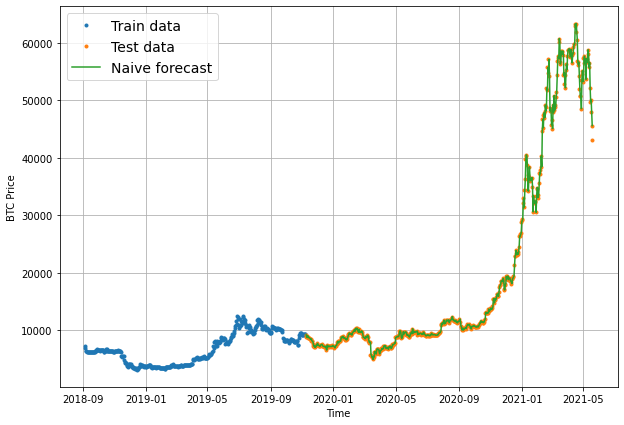

In [19]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, start = 1800, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values = naive_forecast, format = '-', label="Naive forecast")

###Evaluating forecast model
Scale-dependent errors: MAE tf.keras.metrics.mean_absolute_error(), RMSE tf.sqrt(tf.keras.metrics.mean_square_error())

Percentage errors: MAPE tf.keras.metrics.mean_absolute_percentage_error(), sMAPE custom implementation

Scaled errors: MASE See sktime's mase_loss() Less then 1 beats naive predition

In [20]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
    """
    Computes the MEAN-ABSOLUTE SCALED ERROR forcast error for univariate time series prediction.
    """
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))

    return mae / mae_naive_no_season

In [21]:
mean_absolute_scaled_error(y_true = np.array(y_test[1:]), y_pred = np.array(naive_forecast)).numpy()

0.9995699939182624

#### Function to save all results

In [22]:
df_results = pd.DataFrame(columns = ['model', 'MAE', 'RMSE', 'MAPE', 'MASE', 'last_day_pred', 'last_day_real'])

In [23]:
def save_results(model_name, y_pred, y_true = y_test[1:]):
  y_pred = np.array(y_pred)
  y_true = np.array(y_true)
  MAE = int(mean_absolute_error(y_true, y_pred).numpy())
  RMSE = int(tf.sqrt(tf.keras.metrics.mean_squared_error(y_true, y_pred)).numpy())
  MAPE = round(tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred).numpy(),2)
  MASE = mean_absolute_scaled_error(y_true, y_pred).numpy()
  # Account for different sized metrics (for longer horizons, reduce to single number)
  last_day_pred = y_pred[-1]
  df_results.loc[len(df_results)] = [model_name, MAE, RMSE, MAPE, MASE, last_day_pred, y_true[-1]]

In [24]:
save_results('Base_naive', naive_forecast)

In [25]:
df_results

,model,MAE,RMSE,MAPE,MASE,last_day_pred,last_day_real
0,Base_naive,567,1071,2.52,0.99957,45604.615754,43144.471291


### Other models to try
Moving average	https://machinelearningmastery.com/moving-average-smoothing-for-time-series-forecasting-python/

ARIMA (Autoregression Integrated Moving Average)	https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

sktime (Scikit-Learn for time series)	https://github.com/alan-turing-institute/sktime

TensorFlow Decision Forests (random forest, gradient boosting trees)	https://www.tensorflow.org/decision_forests

Facebook Kats (purpose-built forecasting and time series analysis library by Facebook)	https://github.com/facebookresearch/Kats

LinkedIn Greykite (flexible, intuitive and fast forecasts)	https://github.com/linkedin/greykite


### Format Data: Windowing our data
Windowing for one week:

[0,1,2,3,4,5,6] -> [7]

[1,2,3,4,5,6,7] -> [8]

[2,3,4,5,6,7,8] -> [9]

In [26]:
print(f'We want to use: {y_train[:7]} to predict {y_train[7]}')

We want to use: [123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795] to predict 123.033


In [27]:
HORIZON = 1
WINDOW_SIZE = 7

In [28]:
#Create the function to label windowed data
def get_labeled_window(x, horizon = HORIZON):
  """Creates labels for windowed dataset.
  input = [0,1,2,3,4,5,6,7] output = [0,1,2,3,4,5,6], [7]
  """
  return x[:, :-horizon], x[:, -horizon:]

In [29]:
test_window, test_labels = get_labeled_window(tf.expand_dims(tf.range(8), axis = 0))

In [30]:
test_window, test_labels

(<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[0, 1, 2, 3, 4, 5, 6]], dtype=int32)>,
 <tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[7]], dtype=int32)>)

In [31]:
def make_windows(y, window_size = WINDOW_SIZE, horizon = HORIZON):
  """Turns 1D array into sD array of sequental labeled widows"""
  y = np.array(y)
  window_step = np.expand_dims(np.arange(window_size + horizon), axis = 0)
  window_indexes = window_step + np.expand_dims(np.arange(len(y)-(window_size + horizon - 1)), axis=0).T
  # print(f'Window indexes: {window_indexes}\n Window shapes: {window_indexes.shape}')
  windowed_array = y[window_indexes]
  #get labeled windows
  windows, labels = get_labeled_window(windowed_array, horizon = horizon)
  return windows, labels

In [32]:
len(btc_price)

2787

In [33]:
all_windows, all_labels = make_windows(btc_price)

In [34]:
for i in range(3):
  print(f'Window: {all_windows[i]} -> Horizon (label): {all_labels[i]}')

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Horizon (label): [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Horizon (label): [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Horizon (label): [125.96116]


In [35]:
all_windows.shape, all_labels.shape

((2780, 7), (2780, 1))

#### Use tensorflow to create tf.ds
Another way to do this using tf function
 tf.keras.preprocessing.timeseries_dataset_from_array()

In [36]:
test_split = 0.2
split_size = int(len(btc_price) * (1-test_split))
btc_price_train = np.array(btc_price, dtype = 'float32')[:split_size]
btc_price_test = np.array(btc_price, dtype = 'float32')[split_size:]
ds_train = tf.keras.preprocessing.timeseries_dataset_from_array(btc_price_train, 
                                                            targets = btc_price_train[WINDOW_SIZE:], #need to shift right, otherwise give first element
                                                            sequence_length = WINDOW_SIZE, 
                                                            sequence_stride=HORIZON, 
                                                            sampling_rate=HORIZON,
                                                           batch_size = 128)
ds_test = tf.keras.preprocessing.timeseries_dataset_from_array(btc_price_test, 
                                                            targets = btc_price_test[WINDOW_SIZE:], #need to shift right, otherwise give first element
                                                            sequence_length = WINDOW_SIZE, 
                                                            sequence_stride=HORIZON, 
                                                            sampling_rate=HORIZON,
                                                           batch_size = 128)

In [37]:
ds_train, len(ds_train), ds_test, len(ds_test)

(<BatchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>,
 18,
 <BatchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>,
 5)

In [38]:
#Print if batch_size = 1
# for window, label in ds_train.take(3):
#     print(tf.squeeze(window).numpy(), '->', label.numpy())

In [39]:
#Print if batch_size>1
for batch_window, batch_label in ds_train.take(3):
    for window, label in zip(tf.squeeze(batch_window).numpy(), batch_label.numpy()):
      print(window, '->', label)

[123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> 123.033
[125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> 124.049
[108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> 125.96116
[118.67466 121.33866 120.65533 121.795   123.033   124.049   125.96116] -> 125.27966
[121.33866 120.65533 121.795   123.033   124.049   125.96116 125.27966] -> 125.9275
[120.65533 121.795   123.033   124.049   125.96116 125.27966 125.9275 ] -> 126.38333
[121.795   123.033   124.049   125.96116 125.27966 125.9275  126.38333] -> 135.24199
[123.033   124.049   125.96116 125.27966 125.9275  126.38333 135.24199] -> 133.20332
[124.049   125.96116 125.27966 125.9275  126.38333 135.24199 133.20332] -> 142.76334
[125.96116 125.27966 125.9275  126.38333 135.24199 133.20332 142.76334] -> 137.92332
[125.27966 125.9275  126.38333 135.24199 133.20332 142.76334 137.92332] -> 142.95166
[125.9275  126.38333 135.24199 133.20332 142.76334 137.92332 142.95166

In [40]:
btc_price[:24]

[123.65499,
 125.455,
 108.58483,
 118.67466,
 121.33866,
 120.65533,
 121.795,
 123.033,
 124.049,
 125.96116,
 125.27966,
 125.9275,
 126.38333,
 135.24199,
 133.20333,
 142.76333,
 137.92333,
 142.95166,
 152.55183,
 160.33883,
 164.31499,
 177.63333,
 188.29716,
 200.70166]

#### Split data (all_windows and all_labels) to train and test sets

In [41]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [42]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(all_windows, all_labels, test_split=0.2)

In [43]:
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [44]:
train_windows.shape, train_labels.shape

((2224, 7), (2224, 1))

#### Create model checkpoint callback

In [45]:
import os
def checkpoint(model_name, save_path = 'time_series'):
  return tf.keras.callbacks.ModelCheckpoint(filepath = os.path.join(save_path, model_name), 
                                            monitor='val_loss', verbose=0, 
                                            save_best_only=True)

### 1 Model Dense
- A single dense layer with 128 hidden units and ReLU (rectified linear unit) activation
- An output layer with linear activation (or no activation)
- Adam optimizer and MAE loss function
- Batch size of 128
- 100 epochs


#### Build and compile

In [46]:
K.clear_session()

In [47]:
tf.random.set_seed(42)

In [48]:
model_1 = Sequential([Dense(128, activation='relu'),
                      Dense(HORIZON, activation = 'linear')],
                      name = 'Model_1_Dense')

In [49]:
model_1.compile(optimizer='adam', loss = 'mae', metrics = 'mae')

#### Fit model and plot loss curves

In [50]:
history_1 = model_1.fit(train_windows, train_labels, epochs = 100,
                        verbose = 1,
                        validation_data = (test_windows, test_labels),
                        batch_size = 128,
                        callbacks = checkpoint(model_1.name))

Epoch 1/100
18/18 [==============================] - 3s 12ms/step - loss: 780.3455 - mae: 780.3455 - val_loss: 2279.6526 - val_mae: 2279.6526
INFO:tensorflow:Assets written to: time_series/Model_1_Dense/assets
Epoch 2/100
18/18 [==============================] - 0s 6ms/step - loss: 247.6756 - mae: 247.6756 - val_loss: 1005.9991 - val_mae: 1005.9991
INFO:tensorflow:Assets written to: time_series/Model_1_Dense/assets
Epoch 3/100
18/18 [==============================] - 0s 4ms/step - loss: 188.4116 - mae: 188.4116 - val_loss: 923.2862 - val_mae: 923.2862
INFO:tensorflow:Assets written to: time_series/Model_1_Dense/assets
Epoch 4/100
18/18 [==============================] - 0s 5ms/step - loss: 169.4340 - mae: 169.4340 - val_loss: 900.5872 - val_mae: 900.5872
INFO:tensorflow:Assets written to: time_series/Model_1_Dense/assets
Epoch 5/100
18/18 [==============================] - 0s 4ms/step - loss: 165.0895 - mae: 165.0895 - val_loss: 895.2238 - val_mae: 895.2238
INFO:tensorflow:Assets writt

In [51]:
def plot_loss_curves(history):
    """
    Args: TensorFlow model history object
    Returns: separate loss curves for training and validation metrics.
    """
    train_loss = history.history['mae']
    val_loss = history.history['val_mae']
    epochs = range(len(history.history['mae']))

    #Plot Loss
    plt.plot(epochs, train_loss, label = 'Training Loss')
    plt.plot(epochs, val_loss, label = 'Validation Loss')
    plt.title('Loss')
    plt.xlabel('epochs')
    plt.legend()

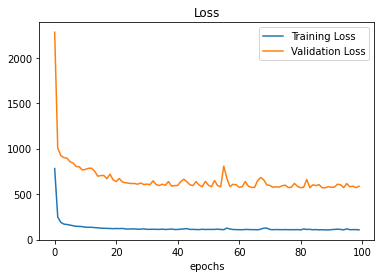

In [52]:
plot_loss_curves(history_1)

#### 1_2 Model: same model with dataset

In [53]:
tf.random.set_seed(42)

In [54]:
model_1_2 = Sequential([InputLayer(input_shape = (7,)),
                        Dense(128, activation='relu'),
                        Dense(HORIZON, activation = 'linear')],
                        name = 'Model_1_2_Dense')

In [55]:
model_1_2.compile(optimizer='adam', loss = 'mae', metrics = 'mae')

In [56]:
history_1_2 = model_1_2.fit(ds_train, epochs = 100,
                            validation_data = ds_test,
                            # batch_size = 128, #It doesn't work here, we had to batch our data set when we created it. Very slow model
                            callbacks = checkpoint(model_1_2.name))

Epoch 1/100
18/18 [==============================] - 1s 35ms/step - loss: 308.7335 - mae: 308.7335 - val_loss: 1356.4836 - val_mae: 1356.4836
INFO:tensorflow:Assets written to: time_series/Model_1_2_Dense/assets
Epoch 2/100
18/18 [==============================] - 1s 32ms/step - loss: 192.7413 - mae: 192.7413 - val_loss: 1015.8676 - val_mae: 1015.8676
INFO:tensorflow:Assets written to: time_series/Model_1_2_Dense/assets
Epoch 3/100
18/18 [==============================] - 1s 31ms/step - loss: 220.3392 - mae: 220.3392 - val_loss: 913.5549 - val_mae: 913.5549
INFO:tensorflow:Assets written to: time_series/Model_1_2_Dense/assets
Epoch 4/100
18/18 [==============================] - 1s 29ms/step - loss: 202.0932 - mae: 202.0932 - val_loss: 912.7422 - val_mae: 912.7422
INFO:tensorflow:Assets written to: time_series/Model_1_2_Dense/assets
Epoch 5/100
18/18 [==============================] - 1s 32ms/step - loss: 177.8976 - mae: 177.8976 - val_loss: 867.8077 - val_mae: 867.8077
INFO:tensorflow:

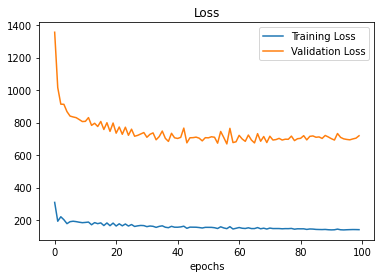

In [57]:
plot_loss_curves(history_1_2)

Why do I have this difference in results?

#### Evaluate model 1 and save results

In [58]:
model_1_load = load_model('time_series/' + model_1.name)

In [59]:
model_1_load.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 568.9512 - mae: 568.9512


[568.951171875, 568.951171875]

#### Function to load best model, make predictions and save in df_results

In [230]:
#Function to load best model, make predictions and save in df_results
def make_predictions(model, test_data = test_windows, test_labels = test_labels, X_test = X_test):
  """
  Function to load best model, make predictions and save in df_results
  Args: model, test_windows = test_windows, test_labels = test_labels, X_test = X_test
  """
  loaded_model  = load_model('time_series/' + model.name)
  pred = loaded_model.predict(test_data)
  save_results(model.name, tf.squeeze(pred), tf.squeeze(test_labels))
  #Plot
  if pred.ndim>0:
    pred = tf.squeeze(pred)
  offset = 300
  plt.figure(figsize=(10, 7))
  # Account for the test_window offset and index into test_labels to ensure correct plotting
  plot_time_series(timesteps = X_test[-len(test_data):], values=test_labels[:, 0], start=offset, label="Test_data")
  plot_time_series(timesteps=X_test[-len(test_data):], values=pred, start=offset, format="-", label=model.name+ " preds")
  return pred

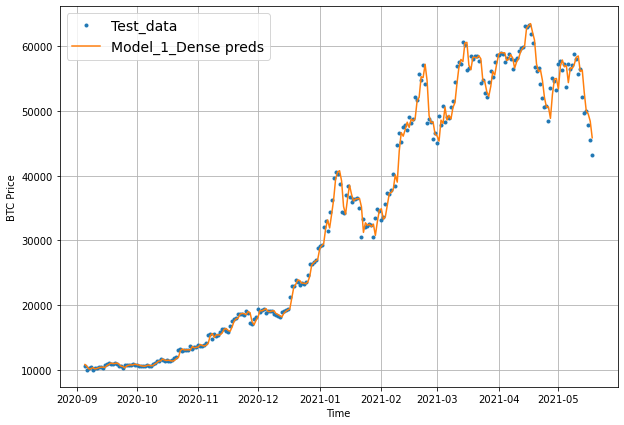

In [61]:
pred_1 = make_predictions(model_1)

In [62]:
df_results

,model,MAE,RMSE,MAPE,MASE,last_day_pred,last_day_real
0,Base_naive,567,1071,2.52,0.99957,45604.615754,43144.471291
1,Model_1_Dense,568,1082,2.54,0.99949,45872.875000,43144.471291


#### Model_1_2 evaluate

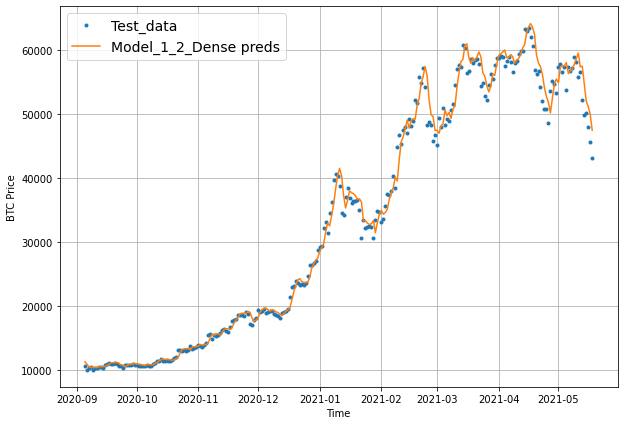

In [63]:
pred_1_2 = make_predictions(model_1_2)

In [64]:
df_results

,model,MAE,RMSE,MAPE,MASE,last_day_pred,last_day_real
0,Base_naive,567,1071,2.52,0.999570,45604.615754,43144.471291
1,Model_1_Dense,568,1082,2.54,0.999490,45872.875000,43144.471291
2,Model_1_2_Dense,664,1232,3.06,1.167849,47401.125000,43144.471291


### 2 Model Dense Window 30 Horizon 1

In [65]:
all_windows_30, all_labels_30 = make_windows(btc_price, window_size = 30)

In [66]:
train_windows_30, test_windows_30, train_labels_30, test_labels_30 = make_train_test_splits(all_windows_30, all_labels_30, test_split=0.2)

In [67]:
tf.random.set_seed(42)

In [68]:
model_2 = Sequential([Dense(128, activation = 'relu'),
                      Dense(HORIZON, activation = 'linear')],
                     name = 'Model_2_Dense_W30')

In [69]:
model_2.compile(optimizer = 'adam', loss = 'mae')

In [70]:
history_2 = model_2.fit(train_windows_30, train_labels_30, epochs = 100,
                        validation_data = (test_windows_30, test_labels_30),
                        batch_size = 128,
                        callbacks = checkpoint(model_2.name))

Epoch 1/100
18/18 [==============================] - 1s 10ms/step - loss: 1097.0397 - val_loss: 3900.2532
INFO:tensorflow:Assets written to: time_series/Model_2_Dense_W30/assets
Epoch 2/100
18/18 [==============================] - 0s 3ms/step - loss: 428.0732 - val_loss: 1587.0747
INFO:tensorflow:Assets written to: time_series/Model_2_Dense_W30/assets
Epoch 3/100
18/18 [==============================] - 0s 4ms/step - loss: 279.7655 - val_loss: 1220.6887
INFO:tensorflow:Assets written to: time_series/Model_2_Dense_W30/assets
Epoch 4/100
18/18 [==============================] - 0s 4ms/step - loss: 224.3637 - val_loss: 1160.1571
INFO:tensorflow:Assets written to: time_series/Model_2_Dense_W30/assets
Epoch 5/100
18/18 [==============================] - 0s 4ms/step - loss: 187.9680 - val_loss: 1007.6487
INFO:tensorflow:Assets written to: time_series/Model_2_Dense_W30/assets
Epoch 6/100
18/18 [==============================] - 0s 4ms/step - loss: 182.9174 - val_loss: 1019.5820
Epoch 7/100
18

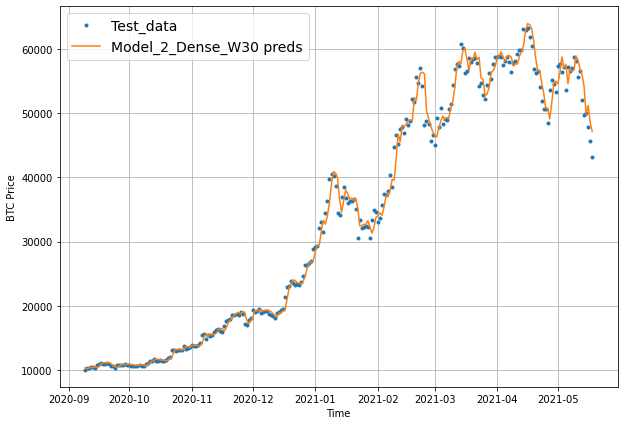

In [71]:
pred_2 = make_predictions(model_2, test_windows=test_windows_30, test_labels = test_labels_30)

In [72]:
df_results

,model,MAE,RMSE,MAPE,MASE,last_day_pred,last_day_real
0,Base_naive,567,1071,2.52,0.999570,45604.615754,43144.471291
1,Model_1_Dense,568,1082,2.54,0.999490,45872.875000,43144.471291
2,Model_1_2_Dense,664,1232,3.06,1.167849,47401.125000,43144.471291
3,Model_2_Dense_W30,608,1132,2.77,1.064470,47168.992188,43144.471291


### 3 Model Dense Window 30 Horizon 7

In [73]:
HORIZON = 7
WINDOW_SIZE = 30

In [74]:
all_windows_30_7, all_labels_30_7 = make_windows(btc_price, window_size = WINDOW_SIZE, horizon = HORIZON)

In [75]:
train_windows_30_7, test_windows_30_7, train_labels_30_7, test_labels_30_7 = make_train_test_splits(all_windows_30_7, all_labels_30_7, test_split=0.2)

In [76]:
train_windows_30_7.shape, train_labels_30_7.shape

((2200, 30), (2200, 7))

In [77]:
K.clear_session()

In [78]:
tf.random.set_seed(42)

In [79]:
model_3 = Sequential([Dense(128, activation = 'relu'),
                      Dense(HORIZON, activation = 'linear')],
                     name = 'Model_3_Dense_W30_7')

In [80]:
model_3.compile(optimizer = 'adam', loss = 'mae')

In [81]:
history_3 = model_3.fit(train_windows_30_7, train_labels_30_7, epochs = 100,
                        validation_data = (test_windows_30_7, test_labels_30_7),
                        batch_size = 128,
                        # verbose = 0,
                        callbacks = checkpoint(model_3.name))

Epoch 1/100
18/18 [==============================] - 0s 10ms/step - loss: 1476.6752 - val_loss: 3088.5618
INFO:tensorflow:Assets written to: time_series/Model_3_Dense_W30_7/assets
Epoch 2/100
18/18 [==============================] - 0s 4ms/step - loss: 552.8943 - val_loss: 2462.4548
INFO:tensorflow:Assets written to: time_series/Model_3_Dense_W30_7/assets
Epoch 3/100
18/18 [==============================] - 0s 5ms/step - loss: 435.1979 - val_loss: 2283.1482
INFO:tensorflow:Assets written to: time_series/Model_3_Dense_W30_7/assets
Epoch 4/100
18/18 [==============================] - 0s 4ms/step - loss: 391.9787 - val_loss: 1975.1218
INFO:tensorflow:Assets written to: time_series/Model_3_Dense_W30_7/assets
Epoch 5/100
18/18 [==============================] - 0s 4ms/step - loss: 357.9485 - val_loss: 2000.1554
Epoch 6/100
18/18 [==============================] - 0s 3ms/step - loss: 332.6705 - val_loss: 1723.4183
INFO:tensorflow:Assets written to: time_series/Model_3_Dense_W30_7/assets
Epoc

In [82]:
load_model_3 = load_model('time_series/Model_3_Dense_W30_7')

In [83]:
load_model_3.evaluate(test_windows_30_7, test_labels_30_7)

18/18 [==============================] - 0s 2ms/step - loss: 1237.5065


1237.5064697265625

In [84]:
model_3.evaluate(test_windows_30_7, test_labels_30_7)

18/18 [==============================] - 0s 2ms/step - loss: 1321.5201


1321.5201416015625

In [85]:
pred_3 = load_model_3.predict(test_windows_30_7)

In [86]:
pred_3[:3], pred_3.shape

(array([[9004.693 , 9048.1   , 9425.088 , 9258.258 , 9495.798 , 9558.451 ,
         9357.354 ],
        [8735.507 , 8840.304 , 9247.793 , 8885.6   , 9097.188 , 9174.329 ,
         9156.819 ],
        [8672.509 , 8782.388 , 9123.8545, 8770.37  , 9007.13  , 9003.87  ,
         9042.723 ]], dtype=float32), (551, 7))

In [87]:
# We can take mean value from prediction. I will try to take a first value to predict first day 
pred_3_first = pred_3[:,0]
pred_3_first[:3], len(pred_3_first), len(test_labels)

(array([9004.693, 8735.507, 8672.509], dtype=float32), 551, 556)

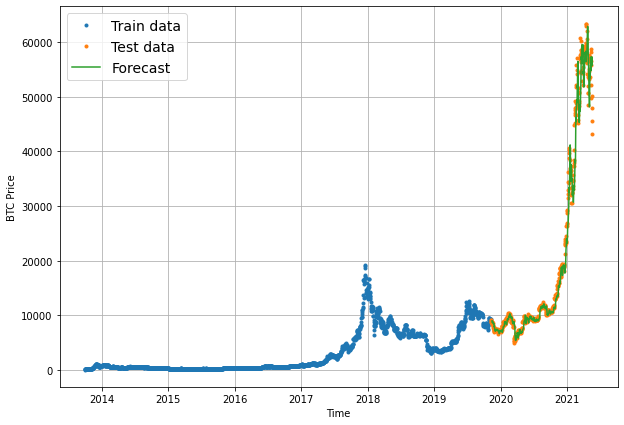

In [88]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[7:], values = pred_3_first, format = '-', label="Forecast")

In [89]:
MAE = int(mean_absolute_error(y_test[7:], pred_3_first).numpy())
RMSE = int(tf.sqrt(tf.keras.metrics.mean_squared_error(y_test[7:], pred_3_first)).numpy())
MAPE = round(tf.keras.metrics.mean_absolute_percentage_error(y_test[7:], pred_3_first).numpy(),2)
MASE = 0
# mean_absolute_scaled_error(y_test[7:], pred_3_first).numpy()
last_day_pred = pred_3_first[-1]
df_results.loc[len(df_results)] = [model_3.name, MAE, RMSE, MAPE, MASE, last_day_pred, y_test[-1]]

In [90]:
df_results

,model,MAE,RMSE,MAPE,MASE,last_day_pred,last_day_real
0,Base_naive,567,1071,2.52,0.999570,45604.615754,43144.471291
1,Model_1_Dense,568,1082,2.54,0.999490,45872.875000,43144.471291
2,Model_1_2_Dense,664,1232,3.06,1.167849,47401.125000,43144.471291
3,Model_2_Dense_W30,608,1132,2.77,1.064470,47168.992188,43144.471291
4,Model_3_Dense_W30_7,1788,3128,7.81,0.000000,55739.140625,43144.471291


### 4 Model Conv1D
Window size 7, horizon 1

The Conv1D layer in TensorFlow takes an input of: (batch_size, timesteps, input_dim).


In [91]:
HORIZON = 1
WINDOW_SIZE = 7

In [92]:
train_windows.shape, test_windows.shape

((2224, 7), (556, 7))

In [93]:
expand_dim_layer = Lambda(lambda x: tf.expand_dims(x, axis = 1))

In [94]:
x = train_windows[0]
print(f'Original shape: {x.shape}')
print(f'Expanded shape: {expand_dim_layer(x).shape}')

Original shape: (7,)
Expanded shape: (7, 1)


In [95]:
tf.random.set_seed(42)

In [96]:
model_4 = Sequential([expand_dim_layer,
                      Conv1D(128, 5, padding = 'same', activation='relu'),
                      Dense(HORIZON, activation = 'linear')],
                     name = 'Model_4_Conv1D')

In [97]:
model_4.compile(optimizer = 'adam', loss = 'mae', metrics = 'mae')

In [98]:
history_4 = model_4.fit(train_windows, train_labels, epochs = 100,
                        validation_data = (test_windows, test_labels),
                        batch_size = 128,
                        callbacks = checkpoint(model_4.name))

Epoch 1/100
18/18 [==============================] - 27s 15ms/step - loss: 1361.8899 - mae: 1361.8899 - val_loss: 1742.1061 - val_mae: 1742.1061
INFO:tensorflow:Assets written to: time_series/Model_4_Conv1D/assets
Epoch 2/100
18/18 [==============================] - 0s 6ms/step - loss: 329.7471 - mae: 329.7471 - val_loss: 1775.2544 - val_mae: 1775.2544
Epoch 3/100
18/18 [==============================] - 0s 5ms/step - loss: 218.6768 - mae: 218.6768 - val_loss: 1245.6897 - val_mae: 1245.6897
INFO:tensorflow:Assets written to: time_series/Model_4_Conv1D/assets
Epoch 4/100
18/18 [==============================] - 0s 5ms/step - loss: 196.2586 - mae: 196.2586 - val_loss: 1083.4241 - val_mae: 1083.4241
INFO:tensorflow:Assets written to: time_series/Model_4_Conv1D/assets
Epoch 5/100
18/18 [==============================] - 0s 6ms/step - loss: 193.0522 - mae: 193.0522 - val_loss: 1083.0670 - val_mae: 1083.0670
INFO:tensorflow:Assets written to: time_series/Model_4_Conv1D/assets
Epoch 6/100
18/

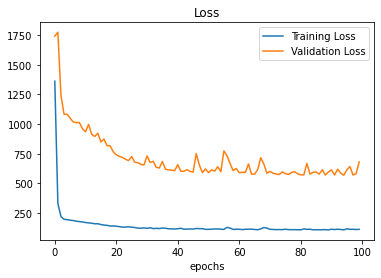

In [99]:
plot_loss_curves(history_4)

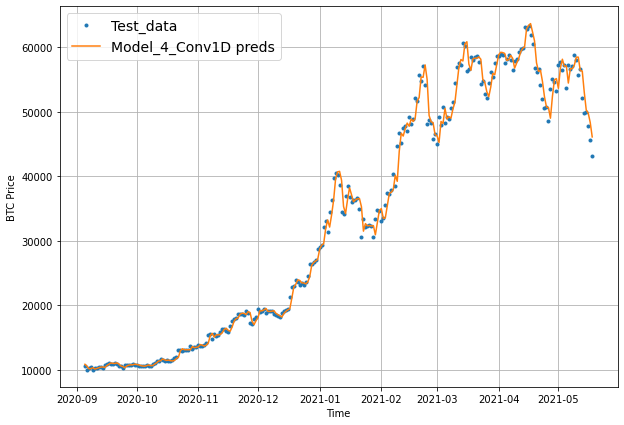

In [100]:
pred_4 = make_predictions(model_4, test_windows = test_windows, test_labels = test_labels)

In [101]:
df_results

,model,MAE,RMSE,MAPE,MASE,last_day_pred,last_day_real
0,Base_naive,567,1071,2.52,0.999570,45604.615754,43144.471291
1,Model_1_Dense,568,1082,2.54,0.999490,45872.875000,43144.471291
2,Model_1_2_Dense,664,1232,3.06,1.167849,47401.125000,43144.471291
3,Model_2_Dense_W30,608,1132,2.77,1.064470,47168.992188,43144.471291
4,Model_3_Dense_W30_7,1788,3128,7.81,0.000000,55739.140625,43144.471291
5,Model_4_Conv1D,567,1082,2.54,0.996957,46118.046875,43144.471291


### 5 Model LSTM

In [102]:
K.clear_session()
tf.random.set_seed(42)

In [103]:
model_5 = Sequential([expand_dim_layer,
                      LSTM(128, return_sequences = True, activation='relu'),
                      LSTM(128, activation='relu'),
                      Dense(128, activation='relu'),
                      Dense(HORIZON, activation='linear')],
                     name = 'Model_5_LSTM_DENSE')

In [104]:
model_5.compile(optimizer='adam', loss = 'mae', metrics = 'mae')

In [105]:
history_5 = model_5.fit(train_windows, train_labels, epochs = 100,
                        validation_data = (test_windows, test_labels),
                        batch_size = 128,
                        callbacks = checkpoint(model_5.name))

Epoch 1/100
18/18 [==============================] - 3s 36ms/step - loss: 2855.6489 - mae: 2855.6489 - val_loss: 13711.9121 - val_mae: 13711.9121
INFO:tensorflow:Assets written to: time_series/Model_5_LSTM_DENSE/assets
Epoch 2/100
18/18 [==============================] - 0s 12ms/step - loss: 826.1332 - mae: 826.1332 - val_loss: 1609.4049 - val_mae: 1609.4049
INFO:tensorflow:Assets written to: time_series/Model_5_LSTM_DENSE/assets
Epoch 3/100
18/18 [==============================] - 0s 13ms/step - loss: 240.9154 - mae: 240.9154 - val_loss: 1581.6028 - val_mae: 1581.6028
INFO:tensorflow:Assets written to: time_series/Model_5_LSTM_DENSE/assets
Epoch 4/100
18/18 [==============================] - 0s 13ms/step - loss: 180.3869 - mae: 180.3869 - val_loss: 914.9314 - val_mae: 914.9314
INFO:tensorflow:Assets written to: time_series/Model_5_LSTM_DENSE/assets
Epoch 5/100
18/18 [==============================] - 0s 14ms/step - loss: 166.5076 - mae: 166.5076 - val_loss: 906.2911 - val_mae: 906.291

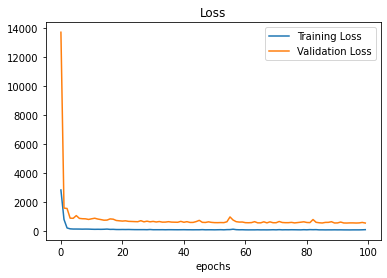

In [106]:
plot_loss_curves(history_5)

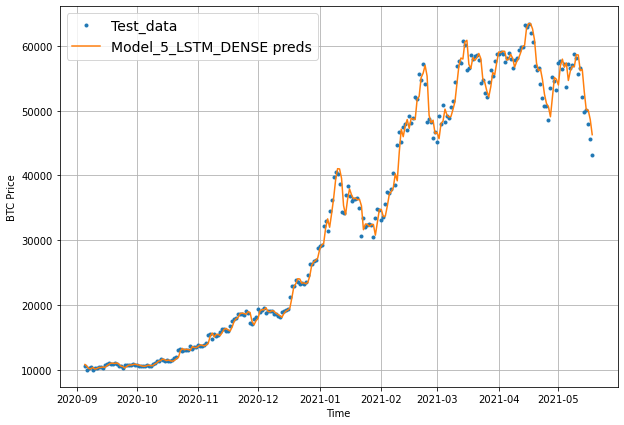

In [107]:
pred_5 = make_predictions(model_5)

In [108]:
df_results

,model,MAE,RMSE,MAPE,MASE,last_day_pred,last_day_real
0,Base_naive,567,1071,2.52,0.999570,45604.615754,43144.471291
1,Model_1_Dense,568,1082,2.54,0.999490,45872.875000,43144.471291
2,Model_1_2_Dense,664,1232,3.06,1.167849,47401.125000,43144.471291
3,Model_2_Dense_W30,608,1132,2.77,1.064470,47168.992188,43144.471291
4,Model_3_Dense_W30_7,1788,3128,7.81,0.000000,55739.140625,43144.471291
5,Model_4_Conv1D,567,1082,2.54,0.996957,46118.046875,43144.471291
6,Model_5_LSTM_DENSE,580,1098,2.61,1.019204,46292.511719,43144.471291


### Make a multivarial dataset

What is the Bitcoin block reward size?

The Bitcoin block reward size is the number of Bitcoin someone receives from mining a Bitcoin block.

At its inception, the Bitcoin block reward size was 50.

But every four years or so, the Bitcoin block reward halves.

For example, the block reward size went from 50 (starting January 2009) to 25 on November 28 2012.



In [109]:
# Block reward values
block_reward_1 = 50 # 3 January 2009 (2009-01-03) - this block reward isn't in our dataset (it starts from 01 October 2013)
block_reward_2 = 25 # 28 November 2012 
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020

# Block reward dates (datetime form of the above date stamps)
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

In [110]:
block_reward_4_datetime

numpy.datetime64('2020-05-11')

In [111]:
df_bc['reward'] = [0.]*len(df_bc)

In [112]:
df_bc.head()

,price,reward
date,,
2013-10-01,123.65499,0.0
2013-10-02,125.45500,0.0
2013-10-03,108.58483,0.0
2013-10-04,118.67466,0.0
2013-10-05,121.33866,0.0


In [113]:
df_bc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   2787 non-null   float64
 1   reward  2787 non-null   float64
dtypes: float64(2)
memory usage: 65.3 KB


In [114]:
# Get date indexes for when to add in different block dates
block_reward_2_days = (block_reward_3_datetime - df_bc.index[0]).days
block_reward_3_days = (block_reward_4_datetime - df_bc.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2414)

In [115]:
# Set values of block_reward column (it's the last column hence -1 indexing on iloc)
df_bc.iloc[:block_reward_2_days, -1] = block_reward_2
df_bc.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
df_bc.iloc[block_reward_3_days:, -1] = block_reward_4
df_bc.head()

,price,reward
date,,
2013-10-01,123.65499,25.0
2013-10-02,125.45500,25.0
2013-10-03,108.58483,25.0
2013-10-04,118.67466,25.0
2013-10-05,121.33866,25.0


In [116]:
df_bc.reward.unique()

array([25.  , 12.5 ,  6.25])

#### Plot new feature

In [117]:
from sklearn.preprocessing import minmax_scale

In [207]:
df_scaled = df_bc.copy()
df_scaled.price = minmax_scale(df_scaled.price)
df_scaled.reward = minmax_scale(df_scaled.reward)

In [208]:
df_scaled.head()

,price,reward
date,,
2013-10-01,0.000238,1.0
2013-10-02,0.000267,1.0
2013-10-03,0.000000,1.0
2013-10-04,0.000160,1.0
2013-10-05,0.000202,1.0


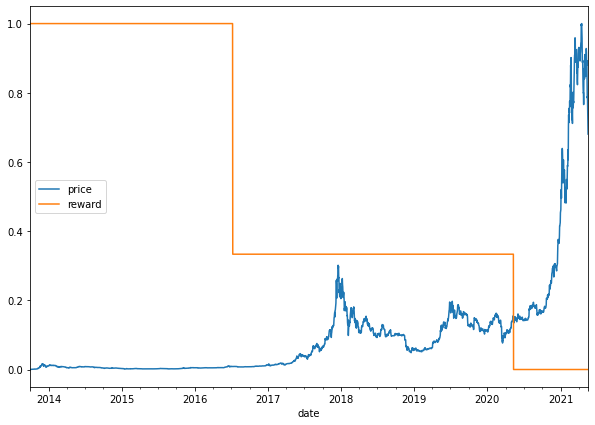

In [209]:
df_scaled.plot(figsize = (10,7))

In [210]:
df_scaled = df_bc.copy() #First i used scaled data, then i read about data leak, as i scaled all dataset at once. I switched back to unscaled data, but didnt change name
df_scaled[7] = df_scaled.price.shift()

In [211]:
for i in range(WINDOW_SIZE - 1, 0, -1):
  df_scaled[i] = df_scaled[i+1].shift()

In [212]:
df_scaled.head(10)

,price,reward,7,6,5,4,3,2,1
date,,,,,,,,,
2013-10-01,123.65499,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25.0,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25.0,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25.0,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25.0,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25.0,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25.0,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25.0,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25.0,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [213]:
df_scaled.dropna(inplace=True)

In [214]:
df_scaled = df_scaled[[1,2,3,4,5,6,7,'reward','price']]

In [215]:
df_scaled.head()

,1,2,3,4,5,6,7,reward,price
date,,,,,,,,,
2013-10-08,123.65499,125.45500,108.58483,118.67466,121.33866,120.65533,121.79500,25.0,123.03300
2013-10-09,125.45500,108.58483,118.67466,121.33866,120.65533,121.79500,123.03300,25.0,124.04900
2013-10-10,108.58483,118.67466,121.33866,120.65533,121.79500,123.03300,124.04900,25.0,125.96116
2013-10-11,118.67466,121.33866,120.65533,121.79500,123.03300,124.04900,125.96116,25.0,125.27966
2013-10-12,121.33866,120.65533,121.79500,123.03300,124.04900,125.96116,125.27966,25.0,125.92750


In [216]:
df_scaled.columns

Index([1, 2, 3, 4, 5, 6, 7, 'reward', 'price'], dtype='object')

In [217]:
WINDOW_SIZE = 7
HORIZON = 1
test_split = 0.2
split_size = int(len(df_scaled) * (1-test_split))

scaled_train = np.array(df_scaled[[1, 2, 3, 4, 5, 6, 7, 'reward']], dtype = 'float32')[:split_size]
scaled_test = np.array(df_scaled[[1, 2, 3, 4, 5, 6, 7, 'reward']], dtype = 'float32')[split_size:]
scaled_labels_train = np.array(df_scaled['price'], dtype = 'float32')[:split_size]
scaled_labels_test = np.array(df_scaled['price'], dtype = 'float32')[split_size:]

scaled_test[:5]


array([[9290.896, 9202.415, 9369.628, 9326.6  , 9335.752, 9226.485,
        8794.358,   12.5  ],
       [9202.415, 9369.628, 9326.6  , 9335.752, 9226.485, 8794.358,
        8798.042,   12.5  ],
       [9369.628, 9326.6  , 9335.752, 9226.485, 8794.358, 8798.042,
        9081.187,   12.5  ],
       [9326.6  , 9335.752, 9226.485, 8794.358, 8798.042, 9081.187,
        8711.534,   12.5  ],
       [9335.752, 9226.485, 8794.358, 8798.042, 9081.187, 8711.534,
        8760.893,   12.5  ]], dtype=float32)

In [218]:
scaled_labels_test[:5]

array([8798.042 , 9081.187 , 8711.534 , 8760.893 , 8749.5205],
      dtype=float32)

### 6 Model, same as 1 but with multivarial dataset

In [241]:
tf.random.set_seed(42)

In [242]:
model_6 = Sequential([Dense(128, activation='relu'),
                        Dense(1, activation = 'linear')],
                        name = 'Model_6_Dense')

In [243]:
model_6.compile(optimizer='adam', loss = 'mae', metrics = 'mae')

In [244]:
history_6 = model_6.fit(scaled_train, scaled_labels_train,
                            epochs = 100,
                            validation_data = (scaled_test, scaled_labels_test),
                            batch_size = 128, 
                            callbacks = checkpoint(model_6.name))

Epoch 1/100
18/18 [==============================] - 1s 11ms/step - loss: 782.1838 - mae: 782.1838 - val_loss: 2252.1772 - val_mae: 2252.1772
INFO:tensorflow:Assets written to: time_series/Model_6_Dense/assets
Epoch 2/100
18/18 [==============================] - 0s 4ms/step - loss: 244.8972 - mae: 244.8972 - val_loss: 1007.1198 - val_mae: 1007.1198
INFO:tensorflow:Assets written to: time_series/Model_6_Dense/assets
Epoch 3/100
18/18 [==============================] - 0s 4ms/step - loss: 186.3308 - mae: 186.3308 - val_loss: 946.3458 - val_mae: 946.3458
INFO:tensorflow:Assets written to: time_series/Model_6_Dense/assets
Epoch 4/100
18/18 [==============================] - 0s 5ms/step - loss: 166.3975 - mae: 166.3975 - val_loss: 897.3853 - val_mae: 897.3853
INFO:tensorflow:Assets written to: time_series/Model_6_Dense/assets
Epoch 5/100
18/18 [==============================] - 0s 4ms/step - loss: 158.6442 - mae: 158.6442 - val_loss: 850.9041 - val_mae: 850.9041
INFO:tensorflow:Assets writt

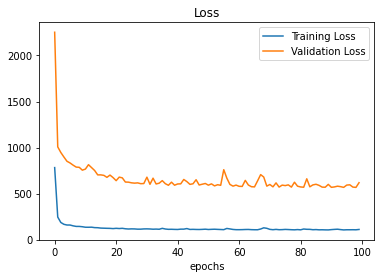

In [245]:
plot_loss_curves(history_6)

In [246]:
loaded_model  = load_model('time_series/' + model_6.name)

pred = loaded_model.predict(scaled_test)

In [247]:
save_results(model_6.name, tf.squeeze(pred), tf.squeeze(scaled_labels_test))

In [248]:
df_results

,model,MAE,RMSE,MAPE,MASE,last_day_pred,last_day_real
0,Base_naive,567,1071,2.52,0.999570,45604.615754,43144.471291
1,Model_1_Dense,568,1082,2.54,0.999490,45872.875000,43144.471291
2,Model_1_2_Dense,664,1232,3.06,1.167849,47401.125000,43144.471291
3,Model_2_Dense_W30,608,1132,2.77,1.064470,47168.992188,43144.471291
4,Model_3_Dense_W30_7,1788,3128,7.81,0.000000,55739.140625,43144.471291
5,Model_4_Conv1D,567,1082,2.54,0.996957,46118.046875,43144.471291
6,Model_5_LSTM_DENSE,580,1098,2.61,1.019204,46292.511719,43144.471291
7,Model_1_3_Dense,567,1081,2.53,0.996671,45936.589844,43144.472656
8,Model_1_3_Dense,567,1081,2.53,0.996671,45936.589844,43144.472656
9,Model_6_Dense,567,1081,2.53,0.996671,45936.589844,43144.472656
